In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.functional import F
from tqdm import tqdm
from torchvision.transforms import Resize
from einops.layers.torch import Rearrange
from torchmetrics.classification import Accuracy
from sklearn.metrics import roc_curve, auc

# Dataclass

In [2]:
class ImageDataset(Dataset):
    def __init__(self, data_paths):
        self.data_paths = data_paths
        file_lists = [os.listdir(data_path) for data_path in self.data_paths]
        X0 = [np.load(os.path.join(self.data_paths[0], file)) for file in tqdm(file_lists[0], desc="Loading files for X0")]
        X1 = [np.load(os.path.join(self.data_paths[1], file)) for file in tqdm(file_lists[1], desc="Loading files for X1")]
        X2 = [np.load(os.path.join(self.data_paths[2], file)) for file in tqdm(file_lists[2], desc="Loading files for X2")]

        self.X = np.concatenate((X0, X1, X2), axis=0)
        self.y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1)), np.full(len(X2), 2)), axis=0)

        np.random.seed(42)

        random_indices = np.random.permutation(len(self.X))
        self.X  = self.X[random_indices]
        self.y = self.y[random_indices]

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return len(self.X)

# Creating train and val dataclasses

In [3]:
dataset_path = '/scratch/arjun.dosajh/ml4sci_task1_data/'

train_dataset = ImageDataset([dataset_path + 'train/no', dataset_path + 'train/sphere', dataset_path + 'train/vort'])
val_dataset = ImageDataset([dataset_path + 'val/no', dataset_path + 'val/sphere', dataset_path + 'val/vort'])

Loading files for X0:   0%|          | 0/10000 [00:00<?, ?it/s]

Loading files for X2: 100%|██████████| 2500/2500 [00:13<00:00, 182.06it/s]


In [4]:
len(train_dataset), len(val_dataset)

(30000, 7500)

In [5]:
x, y = train_dataset[0]
x.shape, y

(torch.Size([1, 150, 150]), tensor(0.))

# ResNet code

In [6]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        self.calculate_accuracy = Accuracy(task='multiclass', num_classes=3, top_k=1)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

# Creating train and val dataloaders

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=10)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, num_workers=10)

# Testing if model.forward() is working properly

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testing_model = ResNet(Bottleneck, [3,4,6,3], 3, 1).to(device)
inputs, labels = next(iter(train_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = testing_model(inputs)
outputs.shape

torch.Size([128, 3])

# Training loop

In [12]:
model = ResNet50 = ResNet(Bottleneck, [3,4,6,3], 3, 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
best_val_acc = 0.0

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy
    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")

    if (epoch + 1) % 5 == 0:
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                accuracy = model.calculate_accuracy(outputs, labels)
                running_loss += loss.item()
                running_accuracy += accuracy
        val_acc = running_accuracy/len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # torch.save(model.state_dict(), f'ckpts/f{model_name}_{lr}_best.pth')
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader)}, Accuracy: {running_accuracy/len(val_loader)}")

print('Finished Training')

100%|██████████| 235/235 [00:38<00:00,  6.06it/s]

Epoch 1, Training loss: 1.1249918344173027, Accuracy: 0.33748891949653625



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 2, Training loss: 1.1154410418043745, Accuracy: 0.3477393388748169



100%|██████████| 235/235 [00:39<00:00,  5.99it/s]

Epoch 3, Training loss: 1.1056755010117876, Accuracy: 0.3571808338165283



100%|██████████| 235/235 [00:39<00:00,  6.00it/s]

Epoch 4, Training loss: 1.0964858070332952, Accuracy: 0.37317153811454773



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 5, Training loss: 1.0725306554043548, Accuracy: 0.4117353558540344



100%|██████████| 59/59 [00:03<00:00, 16.35it/s]

Epoch 5, Validation loss: 1.0756895360300096, Accuracy: 0.4035947024822235



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 6, Training loss: 1.0284915269689356, Accuracy: 0.45198360085487366



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 7, Training loss: 0.9630111597953959, Accuracy: 0.4972628355026245



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 8, Training loss: 0.8665684753275932, Accuracy: 0.558920681476593



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 9, Training loss: 0.7688766185273516, Accuracy: 0.6225177049636841



100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 10, Training loss: 0.6770578937327608, Accuracy: 0.6838984489440918



100%|██████████| 59/59 [00:03<00:00, 15.79it/s]

Epoch 10, Validation loss: 1.8592306617963112, Accuracy: 0.45382192730903625



100%|██████████| 235/235 [00:38<00:00,  6.07it/s]

Epoch 11, Training loss: 0.5683090873221134, Accuracy: 0.7530363202095032



100%|██████████| 235/235 [00:39<00:00,  5.99it/s]

Epoch 12, Training loss: 0.4652624636254412, Accuracy: 0.8067708015441895



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 13, Training loss: 0.37590198865596286, Accuracy: 0.8475841879844666



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 14, Training loss: 0.31597558494578015, Accuracy: 0.8737255930900574



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 15, Training loss: 0.26685008967810486, Accuracy: 0.8947251439094543



100%|██████████| 59/59 [00:03<00:00, 15.63it/s]

Epoch 15, Validation loss: 0.3907785559609785, Accuracy: 0.846196174621582



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 16, Training loss: 0.21975208609662158, Accuracy: 0.915203869342804



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 17, Training loss: 0.19644674148331298, Accuracy: 0.9246786236763



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 18, Training loss: 0.1552179274723885, Accuracy: 0.9403036236763



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 19, Training loss: 0.13569187066973523, Accuracy: 0.9482933878898621



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 20, Training loss: 0.11907610084782255, Accuracy: 0.9548647999763489



100%|██████████| 59/59 [00:03<00:00, 15.56it/s]

Epoch 20, Validation loss: 0.5504898120791225, Accuracy: 0.8383001089096069



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]


Epoch 21, Training loss: 0.09649004516132334, Accuracy: 0.9630762338638306


100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 22, Training loss: 0.09228984681849783, Accuracy: 0.9648492336273193



100%|██████████| 235/235 [00:39<00:00,  6.00it/s]

Epoch 23, Training loss: 0.07499754883031896, Accuracy: 0.9717087745666504



100%|██████████| 235/235 [00:39<00:00,  5.93it/s]

Epoch 24, Training loss: 0.07410734312093638, Accuracy: 0.9739472270011902



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 25, Training loss: 0.058865955615653956, Accuracy: 0.9782025814056396



100%|██████████| 59/59 [00:03<00:00, 15.68it/s]

Epoch 25, Validation loss: 0.6894858757318076, Accuracy: 0.8063322305679321



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 26, Training loss: 0.0543229845728963, Accuracy: 0.9800975322723389



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 27, Training loss: 0.04505290221819218, Accuracy: 0.9839428067207336



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 28, Training loss: 0.04922872262590743, Accuracy: 0.9831560254096985



100%|██████████| 235/235 [00:39<00:00,  5.93it/s]

Epoch 29, Training loss: 0.04737099917367735, Accuracy: 0.9833443760871887



100%|██████████| 235/235 [00:38<00:00,  6.06it/s]

Epoch 30, Training loss: 0.04231956408388833, Accuracy: 0.9840425252914429



100%|██████████| 59/59 [00:03<00:00, 15.79it/s]

Epoch 30, Validation loss: 0.6730225495362686, Accuracy: 0.8256718516349792



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 31, Training loss: 0.04867779072572259, Accuracy: 0.9818483591079712



100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 32, Training loss: 0.03662119934018305, Accuracy: 0.986890435218811



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 33, Training loss: 0.042817567962598294, Accuracy: 0.984275221824646



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 34, Training loss: 0.03356683243888411, Accuracy: 0.9880430102348328



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 35, Training loss: 0.04453456367643431, Accuracy: 0.983455240726471



100%|██████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch 35, Validation loss: 0.7209773119223319, Accuracy: 0.8654869794845581


100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 36, Training loss: 0.027287665049129346, Accuracy: 0.9902592897415161



100%|██████████| 235/235 [00:39<00:00,  5.93it/s]

Epoch 37, Training loss: 0.03225641199684841, Accuracy: 0.9886746406555176



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]


Epoch 38, Training loss: 0.037573573886951865, Accuracy: 0.9861037135124207


100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 39, Training loss: 0.034033244157190175, Accuracy: 0.9881648421287537



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 40, Training loss: 0.028909444260074104, Accuracy: 0.9892730116844177



100%|██████████| 59/59 [00:03<00:00, 15.74it/s]

Epoch 40, Validation loss: 0.7539143365318492, Accuracy: 0.8589080572128296



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 41, Training loss: 0.03749811922873747, Accuracy: 0.9864028692245483



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 42, Training loss: 0.032529619287580566, Accuracy: 0.9887743592262268



100%|██████████| 235/235 [00:38<00:00,  6.05it/s]


Epoch 43, Training loss: 0.021411511162791323, Accuracy: 0.9922206997871399


100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 44, Training loss: 0.03433900628575778, Accuracy: 0.9879654049873352



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 45, Training loss: 0.020500038711829704, Accuracy: 0.992553174495697



100%|██████████| 59/59 [00:03<00:00, 15.86it/s]

Epoch 45, Validation loss: 1.0601263450363936, Accuracy: 0.8562597632408142



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 46, Training loss: 0.03408528165247767, Accuracy: 0.9879764914512634



100%|██████████| 235/235 [00:39<00:00,  6.00it/s]

Epoch 47, Training loss: 0.02568761181963132, Accuracy: 0.9907358288764954



100%|██████████| 235/235 [00:38<00:00,  6.09it/s]


Epoch 48, Training loss: 0.030099941758399314, Accuracy: 0.9893727898597717


100%|██████████| 235/235 [00:39<00:00,  5.93it/s]

Epoch 49, Training loss: 0.023683325217125264, Accuracy: 0.9912233948707581



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 50, Training loss: 0.020663280783597616, Accuracy: 0.9930518269538879



100%|██████████| 59/59 [00:03<00:00, 15.60it/s]

Epoch 50, Validation loss: 0.7205014163154667, Accuracy: 0.8242222666740417



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 51, Training loss: 0.026967877361854103, Accuracy: 0.990669310092926



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 52, Training loss: 0.024933954577476897, Accuracy: 0.9915558099746704



100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 53, Training loss: 0.026993965293018226, Accuracy: 0.9901041388511658



100%|██████████| 235/235 [00:38<00:00,  6.04it/s]

Epoch 54, Training loss: 0.02316655693328048, Accuracy: 0.991134762763977



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 55, Training loss: 0.02347006605680477, Accuracy: 0.991256594657898



100%|██████████| 59/59 [00:03<00:00, 15.98it/s]

Epoch 55, Validation loss: 0.6774694096233885, Accuracy: 0.8378958702087402



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 56, Training loss: 0.019964690126003104, Accuracy: 0.9932845234870911



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 57, Training loss: 0.027407386858249082, Accuracy: 0.9908576607704163



100%|██████████| 235/235 [00:39<00:00,  5.99it/s]

Epoch 58, Training loss: 0.019237893212963132, Accuracy: 0.993417501449585



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 59, Training loss: 0.023051619437087247, Accuracy: 0.9917109608650208



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 60, Training loss: 0.02151735224761069, Accuracy: 0.9926972389221191



100%|██████████| 59/59 [00:03<00:00, 15.70it/s]

Epoch 60, Validation loss: 0.5874954244848025, Accuracy: 0.8828752040863037



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 61, Training loss: 0.016309865803626228, Accuracy: 0.9941710233688354



100%|██████████| 235/235 [00:39<00:00,  6.00it/s]

Epoch 62, Training loss: 0.022311033381327512, Accuracy: 0.9921653270721436



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 63, Training loss: 0.0219117870489928, Accuracy: 0.9923980236053467



100%|██████████| 235/235 [00:39<00:00,  5.93it/s]

Epoch 64, Training loss: 0.01643263265327055, Accuracy: 0.9944592118263245



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 65, Training loss: 0.017923261398112678, Accuracy: 0.994159996509552



100%|██████████| 59/59 [00:03<00:00, 15.88it/s]


Epoch 65, Validation loss: 0.6422952767145835, Accuracy: 0.8834048509597778


100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 66, Training loss: 0.026810337541416842, Accuracy: 0.9904919862747192



100%|██████████| 235/235 [00:39<00:00,  5.92it/s]

Epoch 67, Training loss: 0.010273385677112643, Accuracy: 0.9965314269065857



100%|██████████| 235/235 [00:39<00:00,  5.91it/s]

Epoch 68, Training loss: 0.026542580192487567, Accuracy: 0.9904366135597229



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 69, Training loss: 0.015682298015862545, Accuracy: 0.9947251677513123



100%|██████████| 235/235 [00:38<00:00,  6.03it/s]

Epoch 70, Training loss: 0.015185980251222413, Accuracy: 0.9944481253623962



100%|██████████| 59/59 [00:03<00:00, 15.55it/s]

Epoch 70, Validation loss: 0.747250367019136, Accuracy: 0.8800526857376099



100%|██████████| 235/235 [00:39<00:00,  5.90it/s]

Epoch 71, Training loss: 0.022455373394892533, Accuracy: 0.9921542406082153



100%|██████████| 235/235 [00:39<00:00,  5.91it/s]

Epoch 72, Training loss: 0.019657804633173695, Accuracy: 0.9929521083831787



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 73, Training loss: 0.016684237408372476, Accuracy: 0.9938386082649231



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]

Epoch 74, Training loss: 0.015625390854287654, Accuracy: 0.9946808218955994



100%|██████████| 235/235 [00:39<00:00,  5.93it/s]

Epoch 75, Training loss: 0.018828634235591807, Accuracy: 0.9931183457374573



100%|██████████| 59/59 [00:03<00:00, 15.89it/s]

Epoch 75, Validation loss: 0.6910146616273007, Accuracy: 0.8845130205154419



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 76, Training loss: 0.01476605046377022, Accuracy: 0.9947805404663086



100%|██████████| 235/235 [00:39<00:00,  5.92it/s]

Epoch 77, Training loss: 0.015076492785877409, Accuracy: 0.9944592118263245



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 78, Training loss: 0.017176629061453997, Accuracy: 0.9944148659706116



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 79, Training loss: 0.022871066098834606, Accuracy: 0.9925199151039124



100%|██████████| 235/235 [00:39<00:00,  5.96it/s]

Epoch 80, Training loss: 0.010167577994387953, Accuracy: 0.9965092539787292



100%|██████████| 59/59 [00:03<00:00, 15.57it/s]

Epoch 80, Validation loss: 0.7701748091790636, Accuracy: 0.8599743843078613



100%|██████████| 235/235 [00:39<00:00,  6.00it/s]

Epoch 81, Training loss: 0.017777933718814972, Accuracy: 0.9936613440513611



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 82, Training loss: 0.018724029896622325, Accuracy: 0.9930850863456726



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 83, Training loss: 0.01088211785362875, Accuracy: 0.9965757727622986



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 84, Training loss: 0.008557861051033004, Accuracy: 0.9970523118972778



100%|██████████| 235/235 [00:38<00:00,  6.07it/s]

Epoch 85, Training loss: 0.017943595801455346, Accuracy: 0.993794322013855



100%|██████████| 59/59 [00:03<00:00, 16.53it/s]

Epoch 85, Validation loss: 0.8457600681458489, Accuracy: 0.8682189583778381



100%|██████████| 235/235 [00:38<00:00,  6.12it/s]

Epoch 86, Training loss: 0.01806860591750592, Accuracy: 0.9934840202331543



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]

Epoch 87, Training loss: 0.009192264947403678, Accuracy: 0.9969747066497803



100%|██████████| 235/235 [00:39<00:00,  5.94it/s]

Epoch 88, Training loss: 0.013653774113373266, Accuracy: 0.9952570796012878



100%|██████████| 235/235 [00:38<00:00,  6.03it/s]


Epoch 89, Training loss: 0.0210703769510493, Accuracy: 0.9922983050346375


100%|██████████| 235/235 [00:39<00:00,  5.92it/s]

Epoch 90, Training loss: 0.011795648154517774, Accuracy: 0.9961435794830322



100%|██████████| 59/59 [00:03<00:00, 15.75it/s]

Epoch 90, Validation loss: 0.6431076392783956, Accuracy: 0.8855305314064026



100%|██████████| 235/235 [00:39<00:00,  6.01it/s]


Epoch 91, Training loss: 0.012402277415558854, Accuracy: 0.9953124523162842


100%|██████████| 235/235 [00:38<00:00,  6.07it/s]

Epoch 92, Training loss: 0.013461382814219837, Accuracy: 0.9955562949180603



100%|██████████| 235/235 [00:39<00:00,  5.97it/s]

Epoch 93, Training loss: 0.013873377690795176, Accuracy: 0.995678186416626



100%|██████████| 235/235 [00:38<00:00,  6.03it/s]

Epoch 94, Training loss: 0.008383413186628727, Accuracy: 0.9971409440040588



100%|██████████| 235/235 [00:38<00:00,  6.07it/s]

Epoch 95, Training loss: 0.015701114148721395, Accuracy: 0.9944481253623962



100%|██████████| 59/59 [00:03<00:00, 16.24it/s]

Epoch 95, Validation loss: 0.6234703528679023, Accuracy: 0.8906946778297424



100%|██████████| 235/235 [00:39<00:00,  5.98it/s]


Epoch 96, Training loss: 0.01658434239686764, Accuracy: 0.9940159320831299


100%|██████████| 235/235 [00:38<00:00,  6.12it/s]

Epoch 97, Training loss: 0.00838845078115094, Accuracy: 0.9974068999290466



100%|██████████| 235/235 [00:39<00:00,  5.95it/s]

Epoch 98, Training loss: 0.015529935834731194, Accuracy: 0.99461430311203



100%|██████████| 235/235 [00:39<00:00,  6.02it/s]

Epoch 99, Training loss: 0.009839851975049625, Accuracy: 0.9968417286872864



100%|██████████| 235/235 [00:38<00:00,  6.04it/s]

Epoch 100, Training loss: 0.015095262663399285, Accuracy: 0.9948470592498779



100%|██████████| 59/59 [00:03<00:00, 15.74it/s]

Epoch 100, Validation loss: 0.6944733661110118, Accuracy: 0.8573190569877625
Finished Training


# Best hyperparameters found after performing hyperparameter tuning were:
- learning_rate: `1e-4`
- model: `resnet50`

## Loading saved checkpoint of the best model

In [9]:
model = ResNet(Bottleneck, [3,4,6,3], 3, 1).to(device)
model.load_state_dict(torch.load('ckpts/ResNet50_0.0001_best.pth'))

<All keys matched successfully>

# Evaluating the model using accuracy, ROC curve and AUC value

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.eval()
running_loss = 0.0
running_accuracy = 0.0
all_labels = []
all_outputs = []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(outputs, labels)

        running_loss += loss.item()
        running_accuracy += accuracy
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

val_loss = running_loss/len(val_loader)
val_accuracy = running_accuracy/len(val_loader)

print(f"Validation loss: {val_loss}, Accuracy: {val_accuracy}")

num_classes = outputs.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels, [output[i] for output in all_outputs], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    print(f"Class {i} ROC AUC: {roc_auc[i]}")

  1%|▏         | 3/235 [00:00<00:07, 29.04it/s]

100%|██████████| 235/235 [00:04<00:00, 50.95it/s]

Validation loss: 0.41811068422319564, Accuracy: 0.9203457236289978
Class 0 ROC AUC: 0.98792584
Class 1 ROC AUC: 0.9626974399999999
Class 2 ROC AUC: 0.9842343199999999


# Plotting the ROC curve

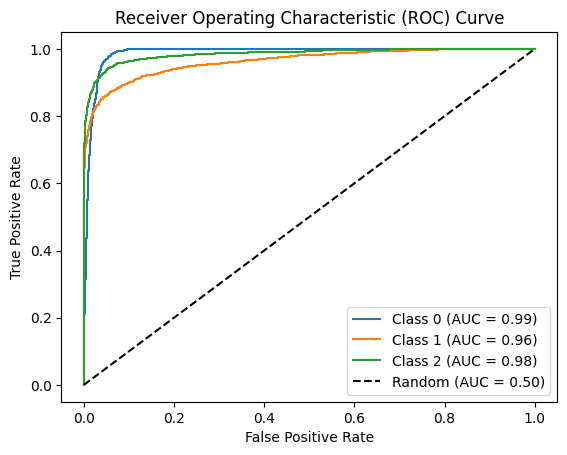

In [12]:
plt.figure()

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()